<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/main/Marfida%20Alexander/A_Marfida_stajirovka_profpatolog_3(norm_1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Стажировка. Профпатолог (INSPECTRUM CLINIC)
- Модели обучения для min/max нормированных данных без удаления строк с NaN в целевом столбце
- Целевые категории:
  - Годен
  - Не годен
  - Ограниченно годен
  - Недостаточно данных для заключения

# ЗАГРУЗКА БИБЛИОТЕК И ДАТАСЕТОВ

In [ ]:
# Подключение библиотек

# Работа с массивами данных
import numpy as np

# Работа с табличными данными
import pandas as pd

# Функции-утилиты для работы с категориальными данными
from tensorflow.keras import utils

# Класс для конструирования последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Оптимизаторы
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, Adagrad, RMSprop

# Токенизатор для преобразования текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Предварительная обработка данных
# from sklearn import preprocessing

# Масштабирование данных
from sklearn.preprocessing import StandardScaler

# Загрузка датасетов из облака google
import gdown

# Регулярные выражения
import re

# Связь с google-диском
from google.colab import files

# Отрисовка графиков
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Создание статистических графиков
import seaborn as sns

# Табличные данные
from fastai.tabular import *

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Разделение данных на выборки
from sklearn.model_selection import train_test_split

# Очистка экрана
from IPython.display import clear_output

# Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

In [ ]:
# Монтирование Goodle-диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# СЛУЖЕБНЫЕ ФУНКЦИИ

Загрузка датасетов

In [ ]:
# x_train_norm_1 = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка Профпатолог/x_train_norm_1.npy')
x_train_norm_1 = np.load('/content/drive/MyDrive/УИИ(maredmi777)/Стажировка Профпатолог/x_train_norm_1.npy')
# y_train_ohe_1 = np.load('/content/drive/MyDrive/УИИ(marphida)/Стажировка Профпатолог/y_train_ohe_1.npy')
y_train_ohe_1 = np.load('/content/drive/MyDrive/УИИ(maredmi777)/Стажировка Профпатолог/y_train_ohe_1.npy')
print(x_train_norm_1.shape)
print(y_train_ohe_1.shape)

(1922, 69)
(1922, 4)


## Функция графиков обучения

In [ ]:
def graphic(loss, accuracy, valloss, valaccuracy, scor, scorloss, exp, param):

  print(
    f'Входных Нейронов: {param[0]}\n',
    f'Значение Dropout: {param[1]}\n',
    f'BatchNormalization: {param[2]}\n',
    f'Средние потери: {param[3]}\n',
    f'Средняя точность на тестовой выборке: {param[4]}\n'
  )
  print('↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓')

  plt.figure(1, figsize=(20, 5))

  plt.subplot(1, 2, 1)
  plt.plot(accuracy, label='Доля верных ответов(train)')
  plt.plot(valaccuracy, label='Доля верных ответов(val)')
#  plt.scatter(19, scor/100, c='r')
  plt.title(f'Опыт№ {exp+1}. Параметры модели: {param}')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.grid(color='gray', linestyle=':')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='train_loss')
  plt.plot(valloss, label='val_loss')
#  plt.scatter(19, scorloss, c='r')
  plt.title(f'Опыт№ {exp+1}, loss')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(color='gray',linestyle=':')
  print()
  plt.show()

## Функция создания модели

In [ ]:
def сreatModel(numN, drop, norm=False, layer2=0, layer3=0):
    # Создание последовательной модели
    model = Sequential()

    if norm:
        model.add(BatchNormalization(input_shape=(x_train.shape[1], )))
        model.add(Dense(numN, activation="relu"))
    else:
        model.add(Dense(numN, input_dim=x_train.shape[1], activation="relu"))

    if layer2 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer2 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    if layer3 > 0:
      model.add(Dense(numN*layer2, input_dim=x_train.shape[1], activation="relu"))
    elif layer3 < 0:
      model.add(Dense(int(numN/(-layer2)), input_dim=x_train.shape[1], activation="relu"))

    model.add(Dropout(drop))
    model.add(Dense(4, activation="softmax")) #

    # Компиляция модели
    model.compile(loss="categorical_crossentropy",
                    optimizer="adam",
                    metrics=["accuracy"])
    return model

## Функция обучения и тестирования модели

In [ ]:
def training(dense_list, drop_list, norm_list, layer2=0, layer3=0):

  parameters = []
  val_accuracy= []
  val_loss_ = []
  accuracy= []
  loss_ = []
  scores = []

  for numN in dense_list:
    for norm in norm_list:
      for drop in drop_list:

        print('Параметры модели: вх.нейр.=', numN, '; откл.нейр.=', drop, '; BatchNormalization=', norm)

        # Создание последовательной модели
        model = сreatModel(numN, drop, norm=norm, layer2=layer2, layer3=layer3)

        # Обучение модели
        history = model.fit(x_train,    # обучающая выборка экземпляры класса
                  y_train,              # обучающая выборка метки класса
                  batch_size=128,       # размер батча
                  epochs=20,            # количество эпох
                  verbose=1,            # 0 - не показывать ход обучения, 1 - показывать
                  validation_data=(x_val, y_val) # выборка для валидации
                  )
        scores = model.evaluate(x_test, y_test)
        print('Точность на тестовой выборке:', scores[1] )

        parameters.append([numN, drop, norm, round(scores[0], 4), round(scores[1], 4)*100])
        val_accuracy.append(history.history['val_accuracy'])
        val_loss_.append(history.history['val_loss'])
        accuracy.append(history.history['accuracy'])
        loss_.append(history.history['loss'])

  return parameters, accuracy, loss_, val_accuracy, val_loss_

## Разделение на обучающую, валидационную и тестовую выборки

In [ ]:
X_tr_n = x_train_norm_1.copy()
# X_tr_o = x_train_ohe_1
# Y_tr_n = y_train_norm_1
Y_tr_o = y_train_ohe_1.copy()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_trn, Y_trn,
                                                    train_size=0.8,
                                                    random_state=42)#, shuffle=False) # shuffle=False - не перемешивать

In [ ]:
train_sep = int(X_tr_n.shape[0] * 0.8)
x_train, x_test, y_train, y_test =  X_tr_n[:train_sep], X_tr_n[train_sep:], Y_tr_o[:train_sep], Y_tr_o[train_sep:]
print('x_train.shape = ', x_train.shape)
print('x_test.shape = ', x_test.shape)
print('y_train.shape = ', y_train.shape)
print('y_test.shape', y_test.shape)
print()
val_sep = int(x_train.shape[0] * 0.8)
x_train, x_val, y_train, y_val = x_train[:val_sep], x_train[val_sep:], y_train[:val_sep], y_train[val_sep:]
print('x_train.shape = ', x_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_train.shape = ', y_train.shape)
print('y_val.shape', y_val.shape)


x_train.shape =  (1537, 69)
x_test.shape =  (385, 69)
y_train.shape =  (1537, 4)
y_test.shape (385, 4)

x_train.shape =  (1229, 69)
x_val.shape =  (308, 69)
y_train.shape =  (1229, 4)
y_val.shape (308, 4)


## Создание модели

In [ ]:
model1 = сreatModel(64, 0.1, True)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 69)               276       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 64)                4480      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,016
Trainable params: 4,878
Non-trainable params: 138
_________________________________________________________________


In [ ]:
y_train

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

### Списки гиперпараметров

In [ ]:
dense_param = [32, 64, 128, 256]             # кол-во нейронов во входном слое
drop_param  = [0.01, 0.25]        # доля отключаемых нейронов, слой Dropout
norm_param = [False, True]             # для BatchNormalization

### Обучение модели с одним слоем

In [ ]:
par, acc, loss, val_acc, val_loss = training(dense_param, drop_param, norm_param)

Параметры модели: вх.нейр.= 32 ; откл.нейр.= 0.01 ; BatchNormalization= False
Epoch 1/20
10/10 [==============================] - 5s 27ms/step - loss: 1.4289 - accuracy: 0.1391 - val_loss: 1.4330 - val_accuracy: 0.2013
Epoch 2/20
10/10 [==============================] - 0s 6ms/step - loss: 1.1762 - accuracy: 0.5484 - val_loss: 1.2799 - val_accuracy: 0.5487
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.9620 - accuracy: 0.8389 - val_loss: 1.1600 - val_accuracy: 0.6299
Epoch 4/20
10/10 [==============================] - 0s 6ms/step - loss: 0.7979 - accuracy: 0.8438 - val_loss: 1.0886 - val_accuracy: 0.6299
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.6869 - accuracy: 0.8438 - val_loss: 1.0509 - val_accuracy: 0.6299
Epoch 6/20
10/10 [==============================] - 0s 6ms/step - loss: 0.6180 - accuracy: 0.8438 - val_loss: 1.0166 - val_accuracy: 0.6299
Epoch 7/20
10/10 [==============================] - 0s 6ms/step - loss: 0.5790 - 

In [ ]:
print(acc[1])
print(val_acc[1], '\n')
print(loss[1])
print(val_loss[1])

In [ ]:
par

#### Сводные результаты обучения

In [ ]:
col = [' Число Нейронов ', ' Значение Dropout ',' BatchNormalization? ',' Loss тестовой ', ' Точность тестовой ']
df = pd.DataFrame(par, columns = col, index= np.arange(1, len(par)+1))
df

Число Нейронов    Значение Dropout    BatchNormalization?   \
1                 32                0.01                  False   
2                 32                0.25                  False   
3                 32                0.01                   True   
4                 32                0.25                   True   
5                 64                0.01                  False   
6                 64                0.25                  False   
7                 64                0.01                   True   
8                 64                0.25                   True   
9                128                0.01                  False   
10               128                0.25                  False   
11               128                0.01                   True   
12               128                0.25                   True   
13               256                0.01                  False   
14               256                0.25                  False   
15               256                0.01                   True   
16               256                0.25                   True   

     Loss тестовой    Точность тестовой   
1            0.6124                74.29  
2            0.6119                74.03  
3            0.6080                75.06  
4            0.6118                74.81  
5            0.5930                74.55  
6            0.5996                75.06  
7            0.6336                75.32  
8            0.6102                74.81  
9            0.6254                73.51  
10           0.6175                74.29  
11           0.5651                76.62  
12           0.5835                76.10  
13           0.6728                73.77  
14           0.6521                72.73  
15           0.5702                77.40  
16           0.5734                76.88

#### Графики обучения

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.6124
 Средняя точность на тестовойой выборке: 74.29

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



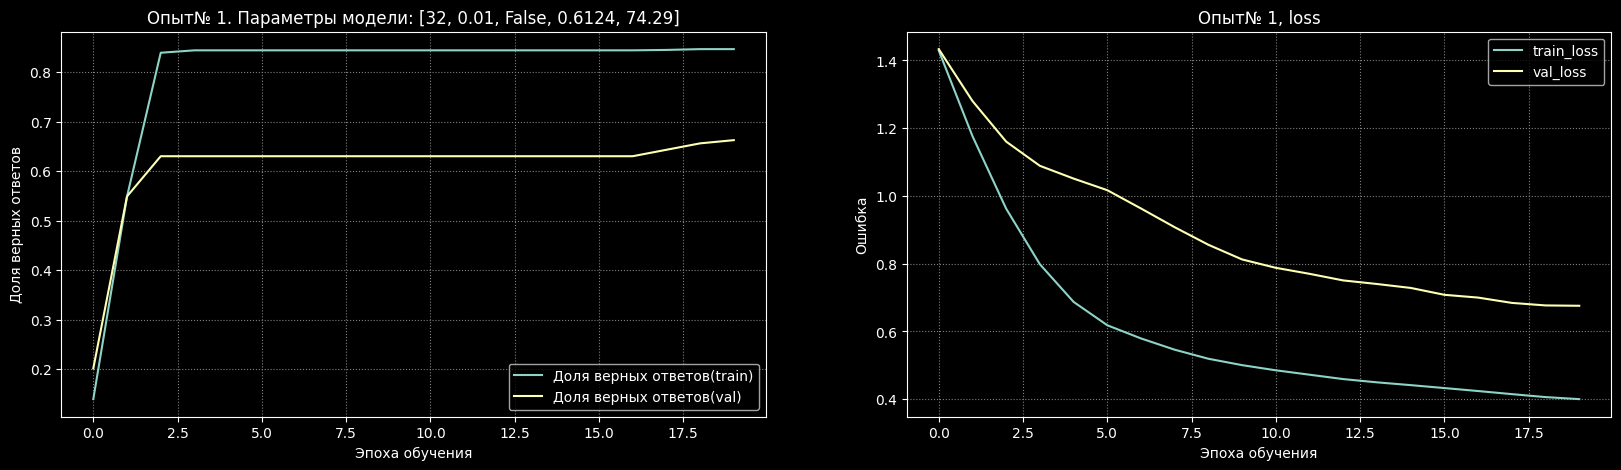

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.6119
 Средняя точность на тестовойой выборке: 74.03

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



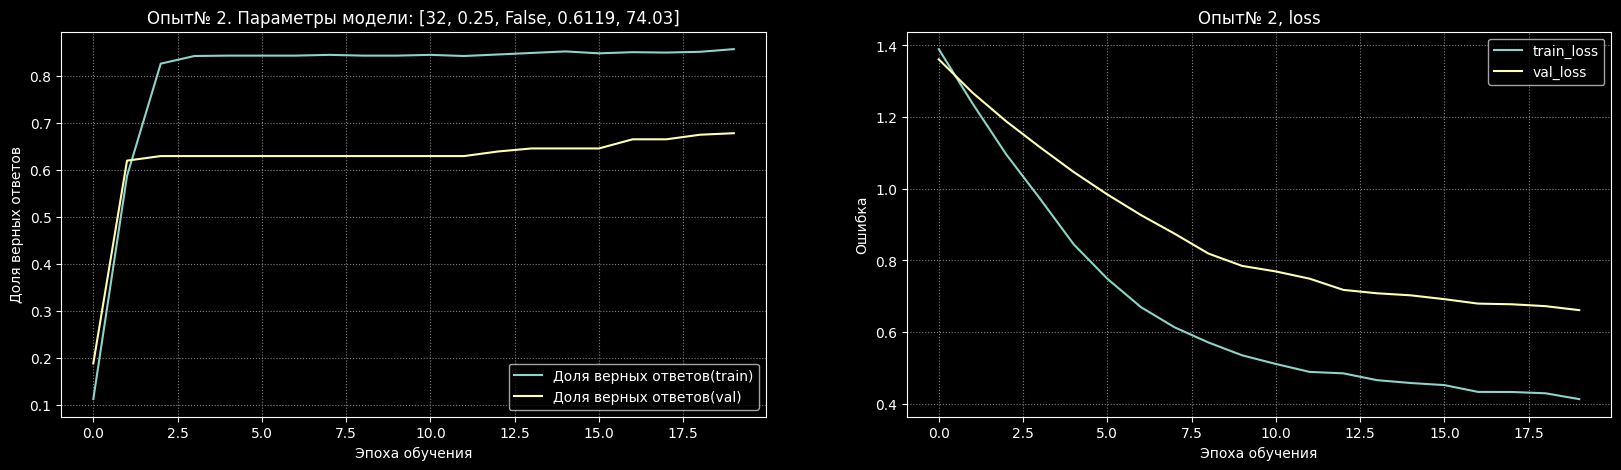

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.608
 Средняя точность на тестовойой выборке: 75.06

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



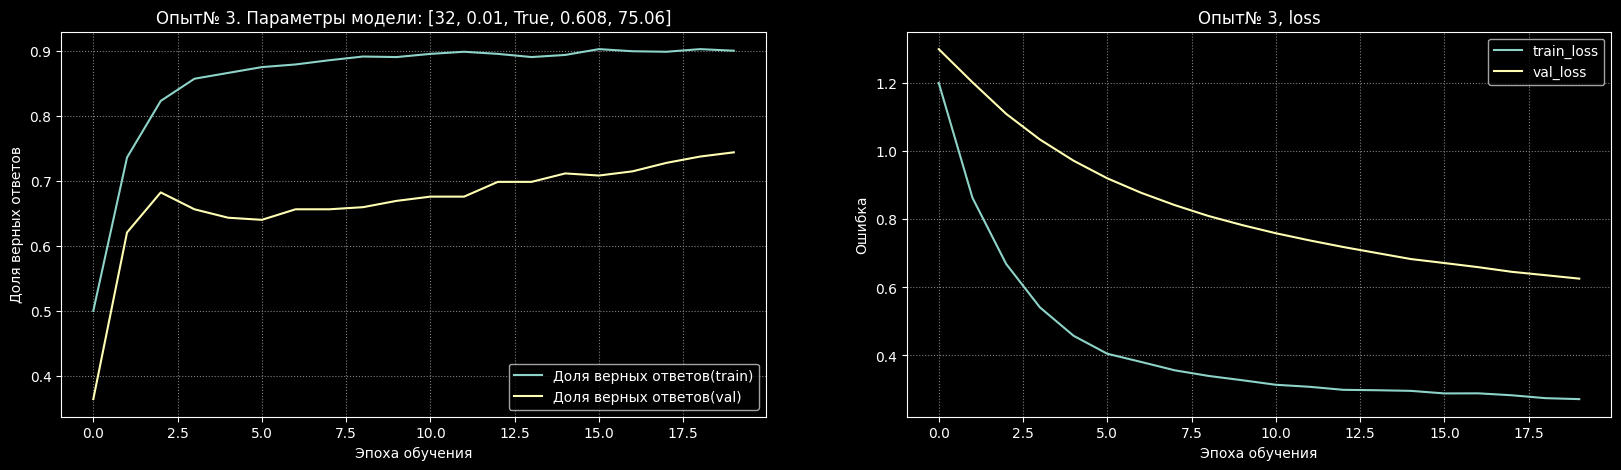

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.6118
 Средняя точность на тестовойой выборке: 74.81

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



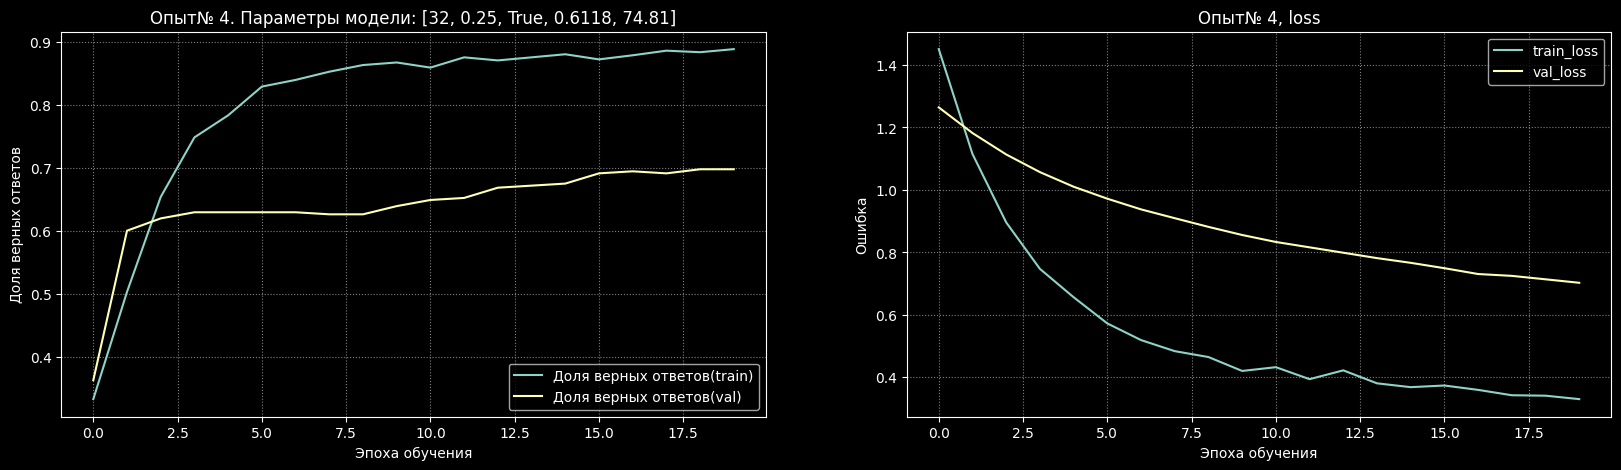

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.593
 Средняя точность на тестовойой выборке: 74.55000000000001

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



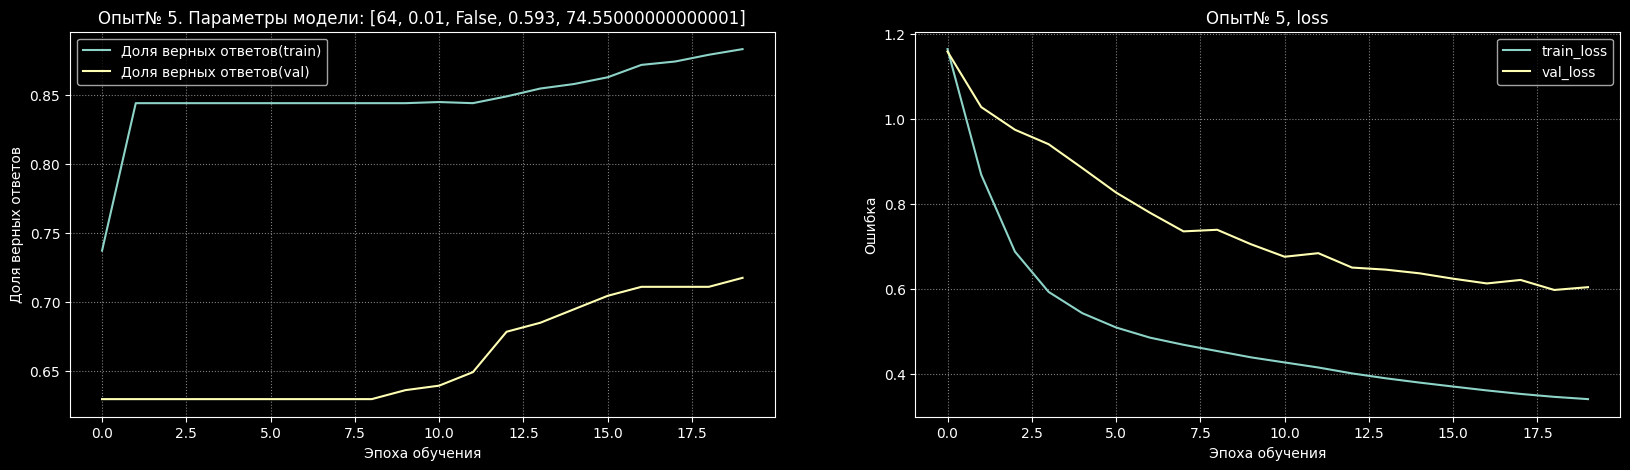

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.5996
 Средняя точность на тестовойой выборке: 75.06

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



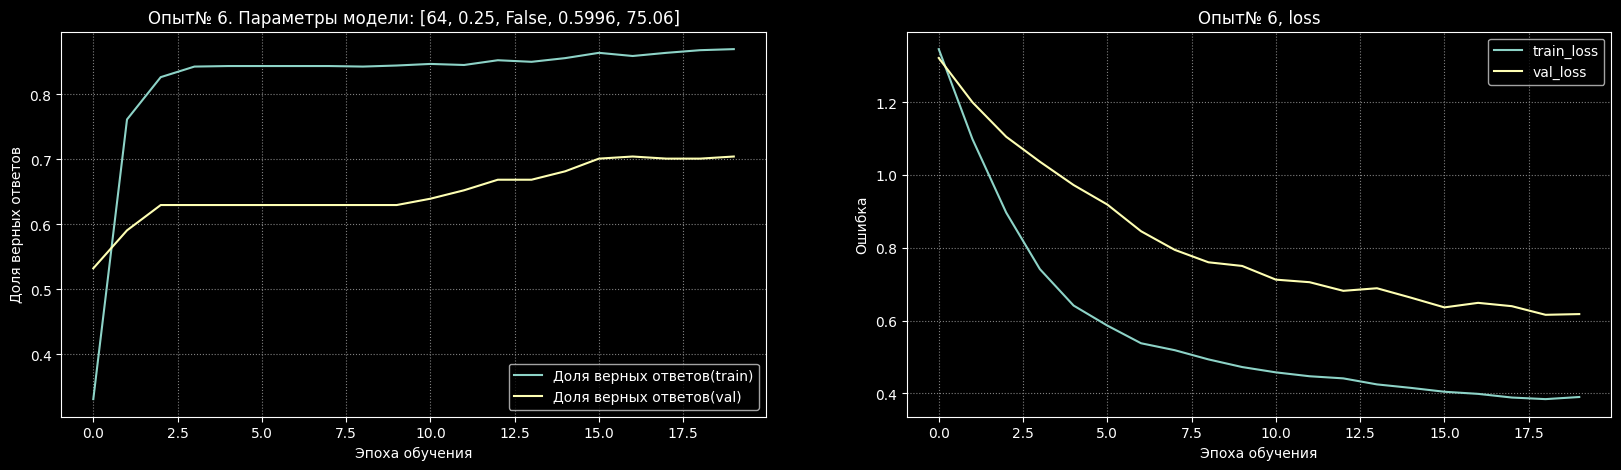

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.6336
 Средняя точность на тестовойой выборке: 75.32

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



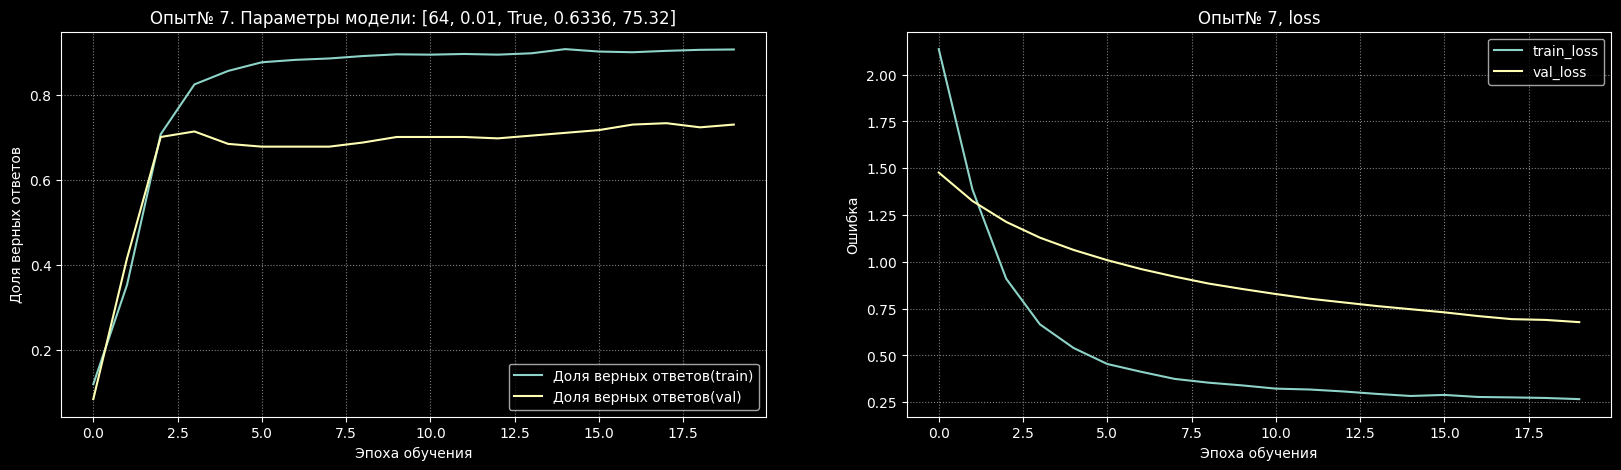

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.6102
 Средняя точность на тестовойой выборке: 74.81

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



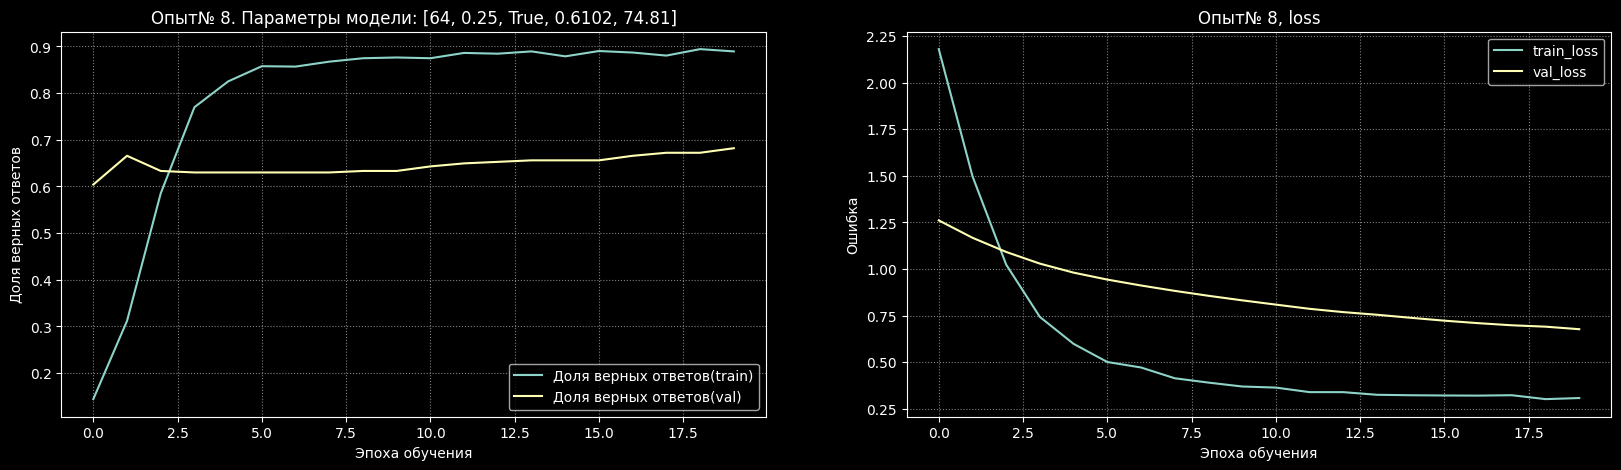

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.6254
 Средняя точность на тестовойой выборке: 73.50999999999999

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



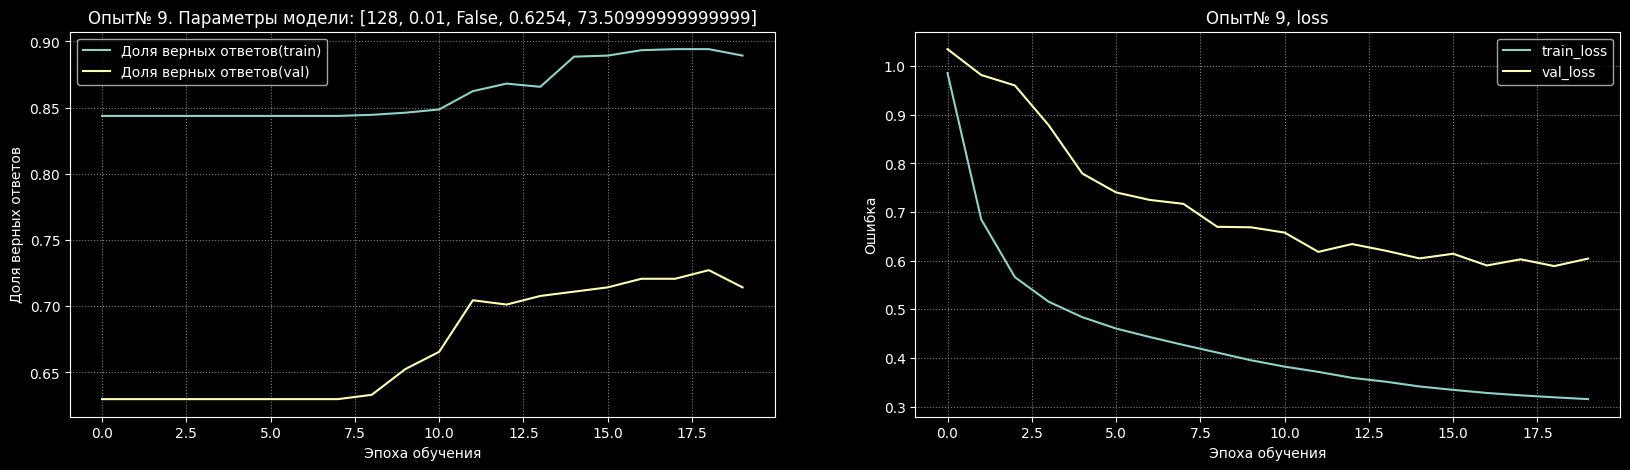

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.6175
 Средняя точность на тестовойой выборке: 74.29

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



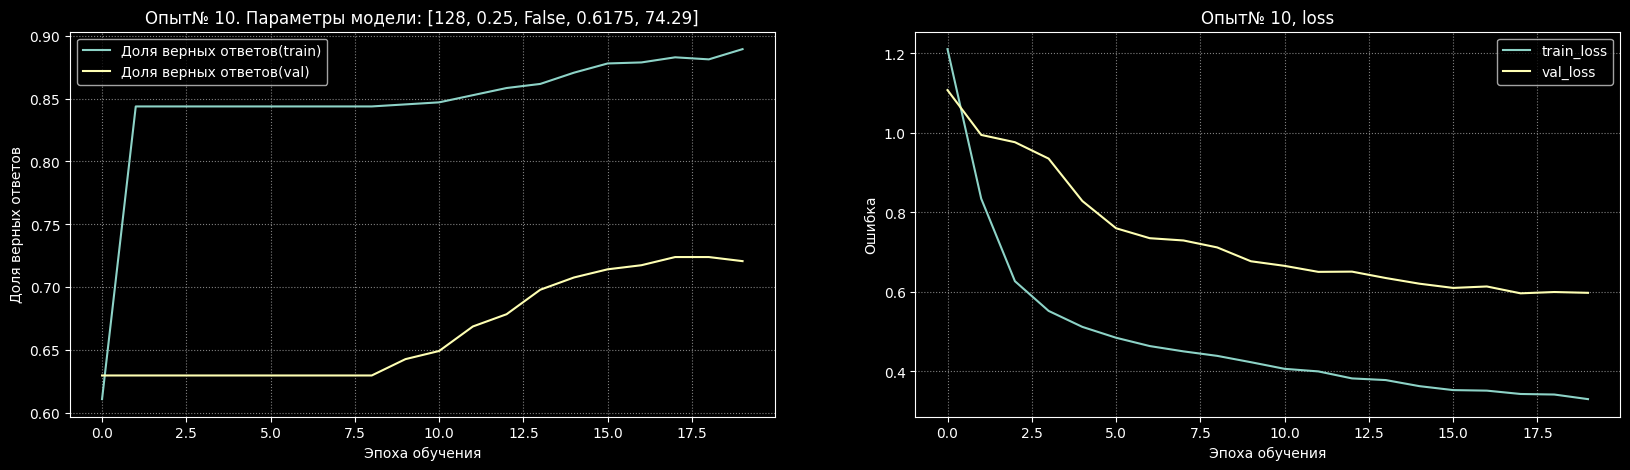

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.5651
 Средняя точность на тестовойой выборке: 76.62

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



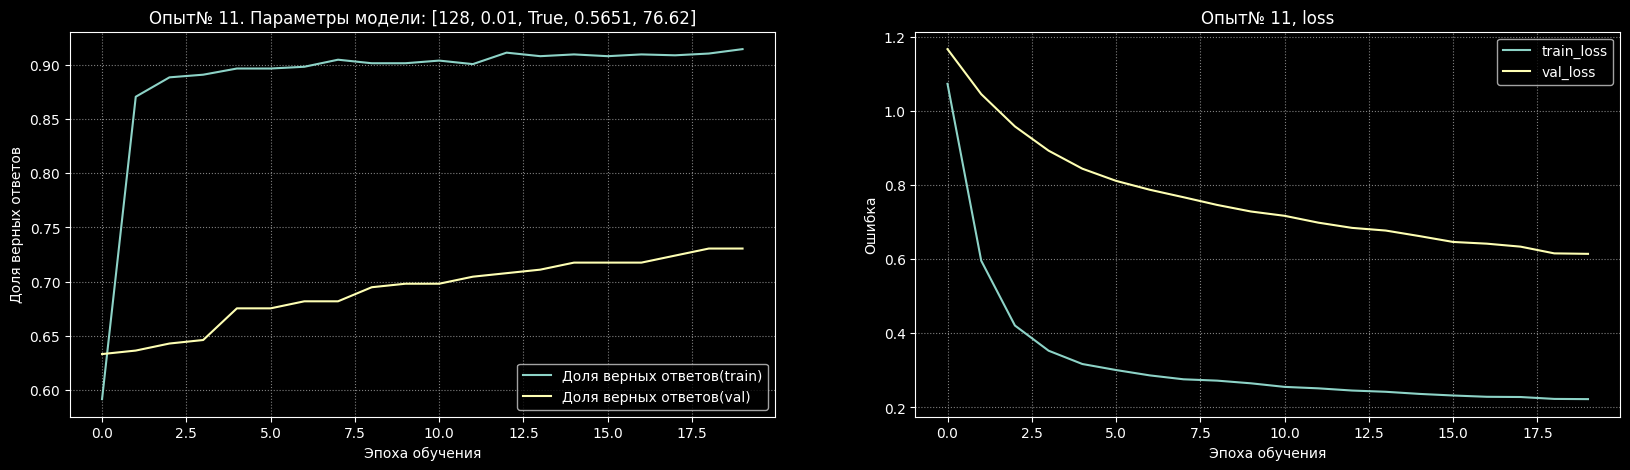

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.5835
 Средняя точность на тестовойой выборке: 76.1

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



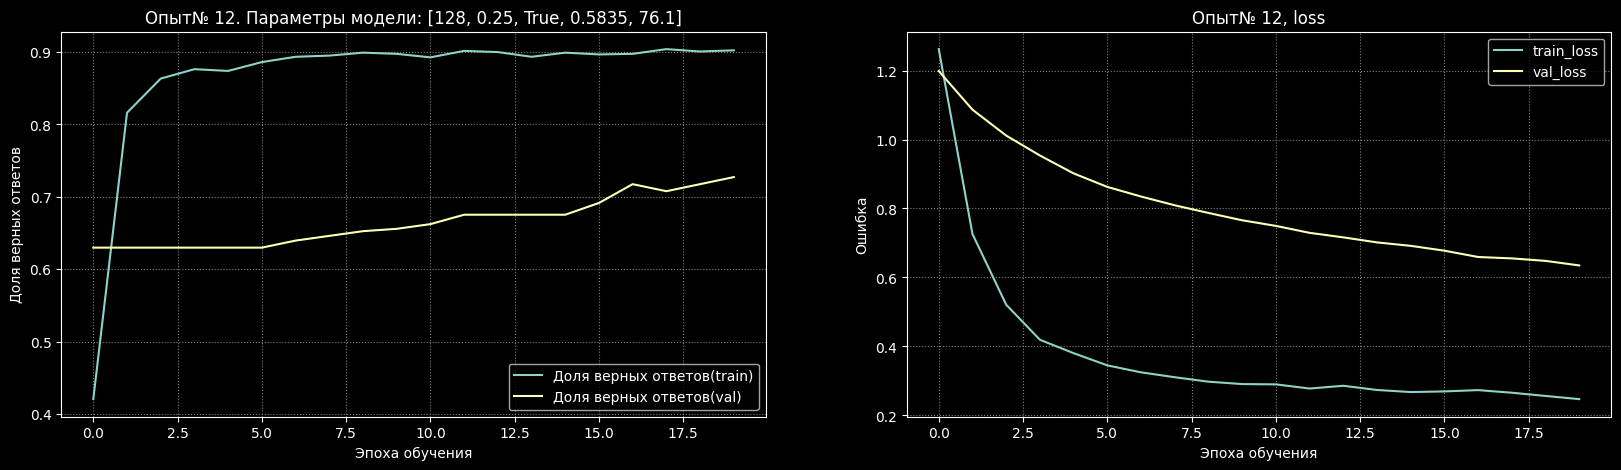

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.6728
 Средняя точность на тестовойой выборке: 73.77

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



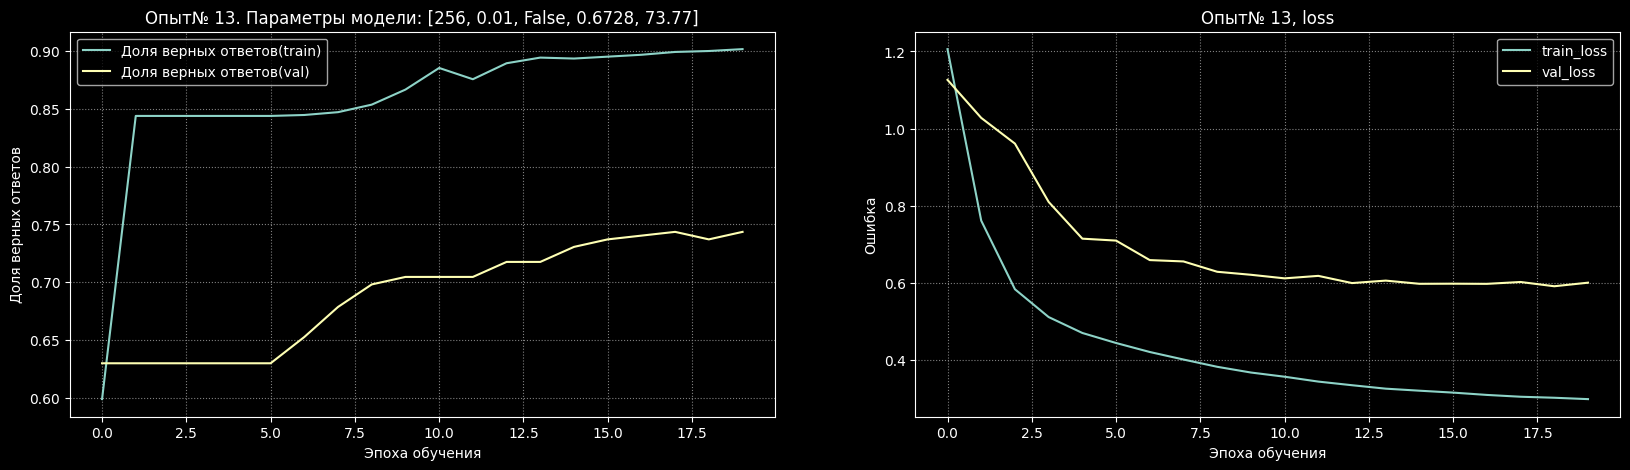

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.6521
 Средняя точность на тестовойой выборке: 72.72999999999999

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



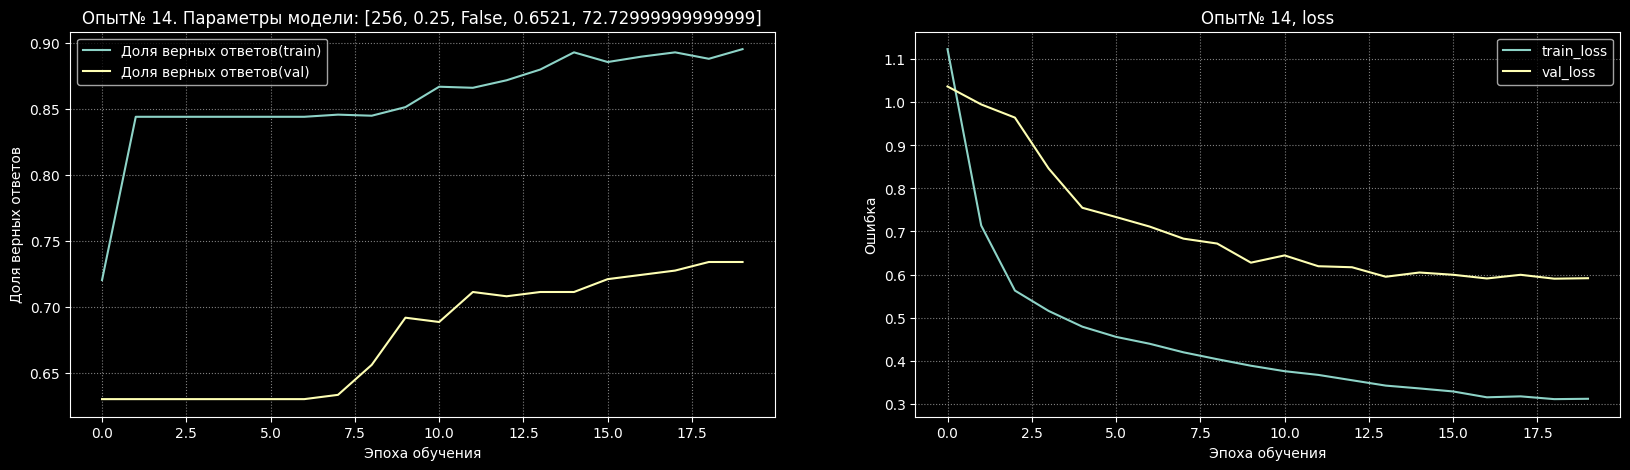

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.5702
 Средняя точность на тестовойой выборке: 77.4

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



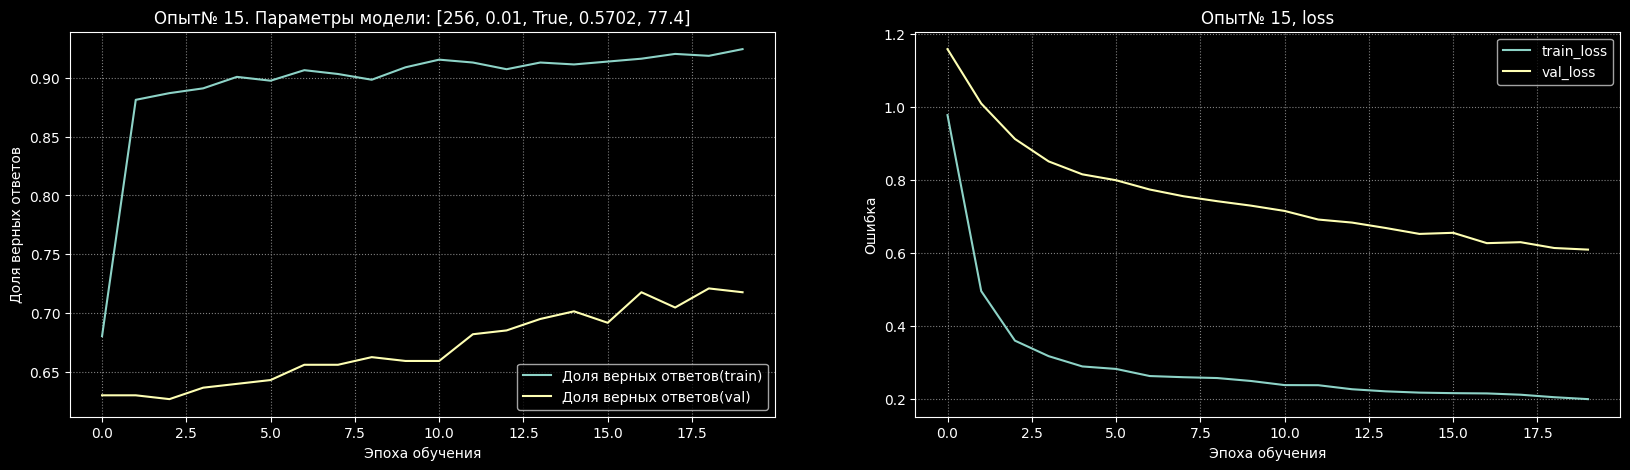

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.5734
 Средняя точность на тестовойой выборке: 76.88000000000001

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



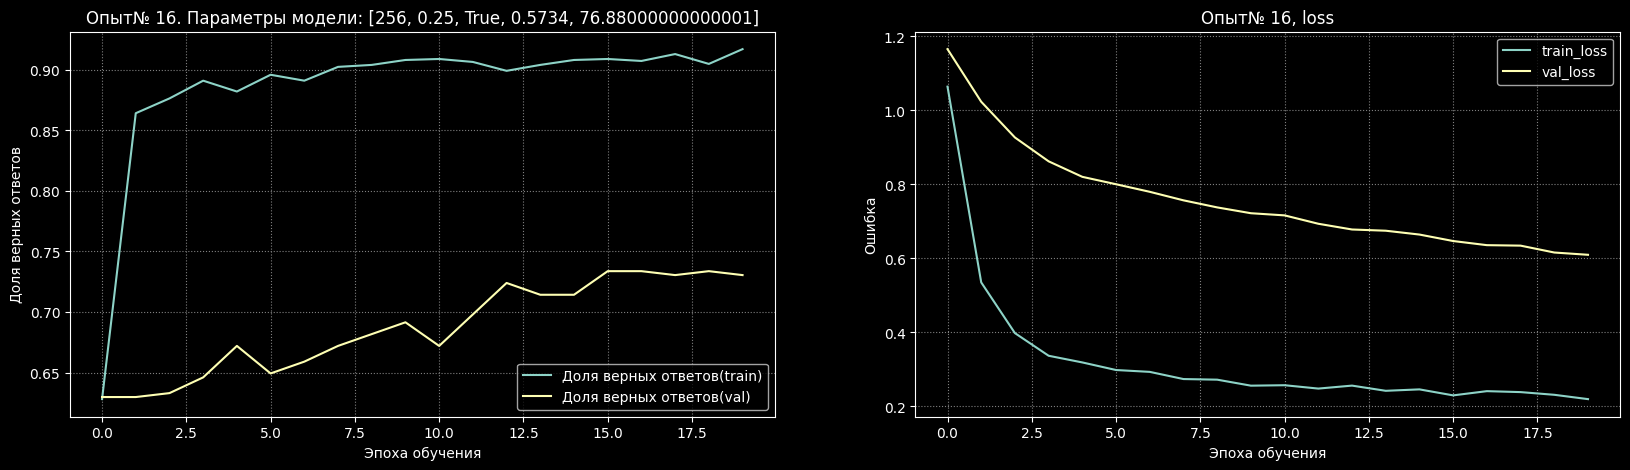

In [ ]:
for exp in range(len(val_loss)):
    graphic(loss[exp], acc[exp], val_loss[exp], val_acc[exp],
            par[exp][-1], par[exp][-2], exp, par[exp])


### Обучение модели с двумя слоями

In [ ]:
par, acc, loss, val_acc, val_loss = training(dense_param, drop_param, norm_param, 4)

Параметры модели: вх.нейр.= 32 ; откл.нейр.= 0.01 ; BatchNormalization= False
Epoch 1/20
10/10 [==============================] - 2s 26ms/step - loss: 1.1989 - accuracy: 0.6981 - val_loss: 1.1067 - val_accuracy: 0.6299
Epoch 2/20
10/10 [==============================] - 0s 7ms/step - loss: 0.8582 - accuracy: 0.8438 - val_loss: 0.9583 - val_accuracy: 0.6299
Epoch 3/20
10/10 [==============================] - 0s 9ms/step - loss: 0.6090 - accuracy: 0.8438 - val_loss: 1.0389 - val_accuracy: 0.6299
Epoch 4/20
10/10 [==============================] - 0s 9ms/step - loss: 0.5394 - accuracy: 0.8438 - val_loss: 0.9430 - val_accuracy: 0.6299
Epoch 5/20
10/10 [==============================] - 0s 7ms/step - loss: 0.4926 - accuracy: 0.8438 - val_loss: 0.7650 - val_accuracy: 0.6299
Epoch 6/20
10/10 [==============================] - 0s 7ms/step - loss: 0.4698 - accuracy: 0.8438 - val_loss: 0.7518 - val_accuracy: 0.6299
Epoch 7/20
10/10 [==============================] - 0s 9ms/step - loss: 0.4516 - 

#### Сводные результаты обучения

In [ ]:
print('2-й слой нейронов = Вх. слой * 4')
col = [' Число Нейронов ', ' Значение Dropout ',' BatchNormalization? ',' Loss тестовой ', ' Точность тестовой ']
df = pd.DataFrame(par, columns = col, index= np.arange(1, len(par)+1))
df

2-й слой нейронов = Вх. слой * 4


Число Нейронов    Значение Dropout    BatchNormalization?   \
1                 32                0.01                  False   
2                 32                0.25                  False   
3                 32                0.01                   True   
4                 32                0.25                   True   
5                 64                0.01                  False   
6                 64                0.25                  False   
7                 64                0.01                   True   
8                 64                0.25                   True   
9                128                0.01                  False   
10               128                0.25                  False   
11               128                0.01                   True   
12               128                0.25                   True   
13               256                0.01                  False   
14               256                0.25                  False   
15               256                0.01                   True   
16               256                0.25                   True   

     Loss тестовой    Точность тестовой   
1            0.6923                71.95  
2            0.6737                72.73  
3            0.5724                76.88  
4            0.5881                75.58  
5            0.7705                70.39  
6            0.6922                72.99  
7            0.5477                77.66  
8            0.5482                77.14  
9            0.7280                70.65  
10           0.7540                70.65  
11           0.6331                75.58  
12           0.6295                76.10  
13           0.7216                74.03  
14           0.7247                73.25  
15           0.6549                76.62  
16           0.6223                77.14

#### Графики обучения

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.6923
 Средняя точность на тестовойой выборке: 71.95

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



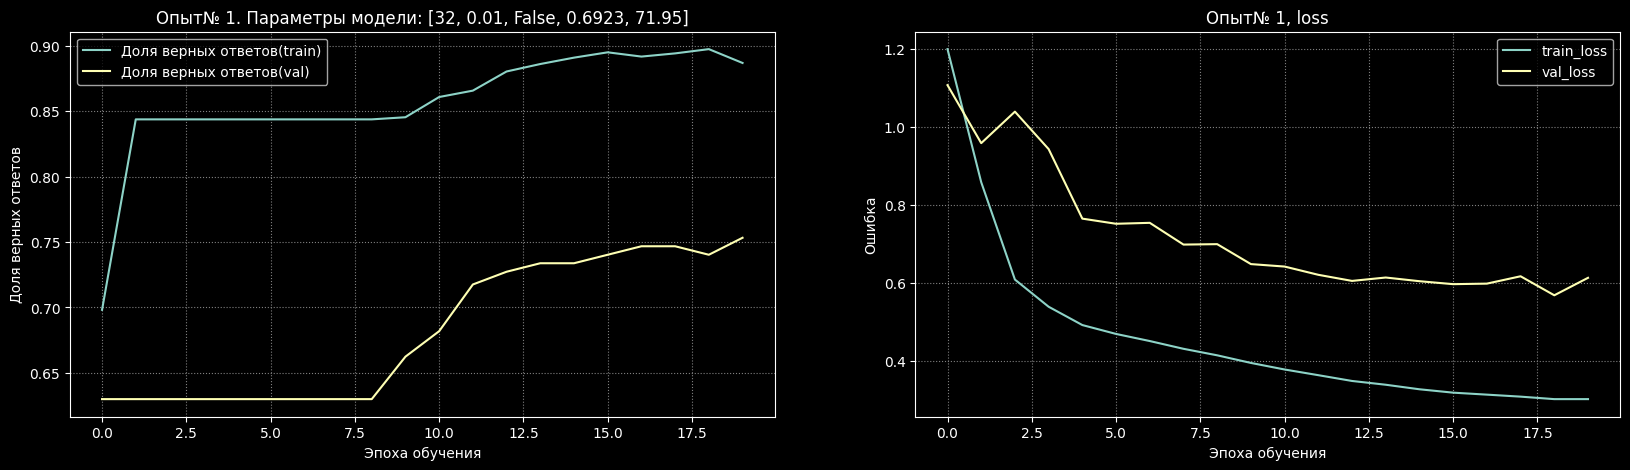

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.6737
 Средняя точность на тестовойой выборке: 72.72999999999999

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



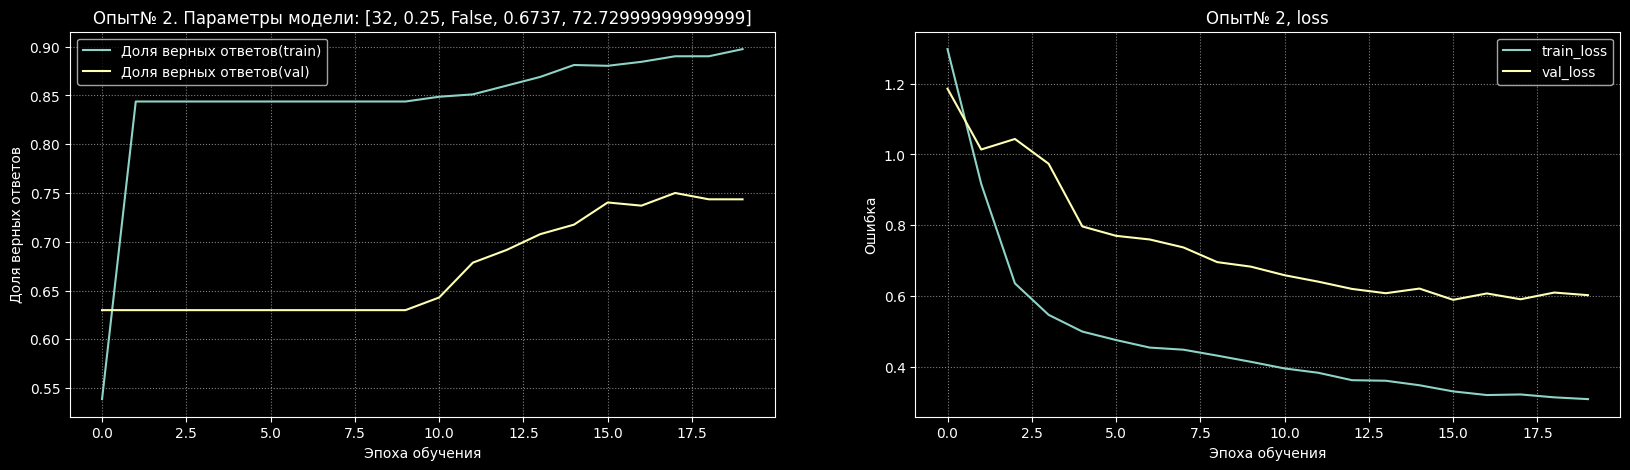

Входных Нейронов: 32
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.5724
 Средняя точность на тестовойой выборке: 76.88000000000001

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



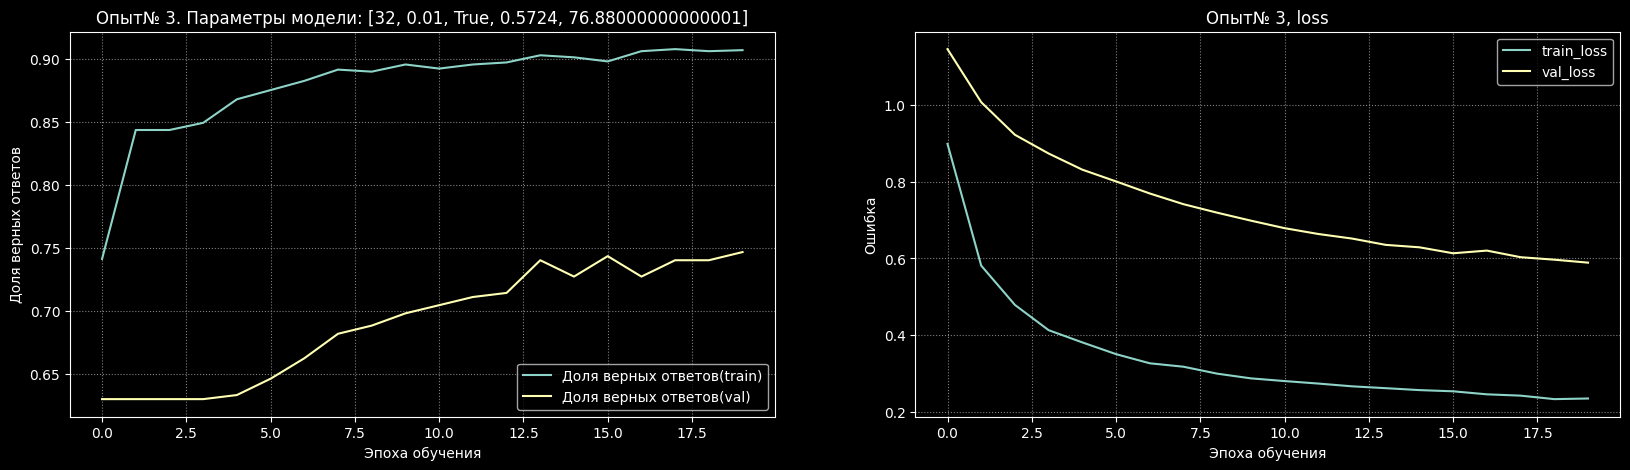

Входных Нейронов: 32
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.5881
 Средняя точность на тестовойой выборке: 75.58

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



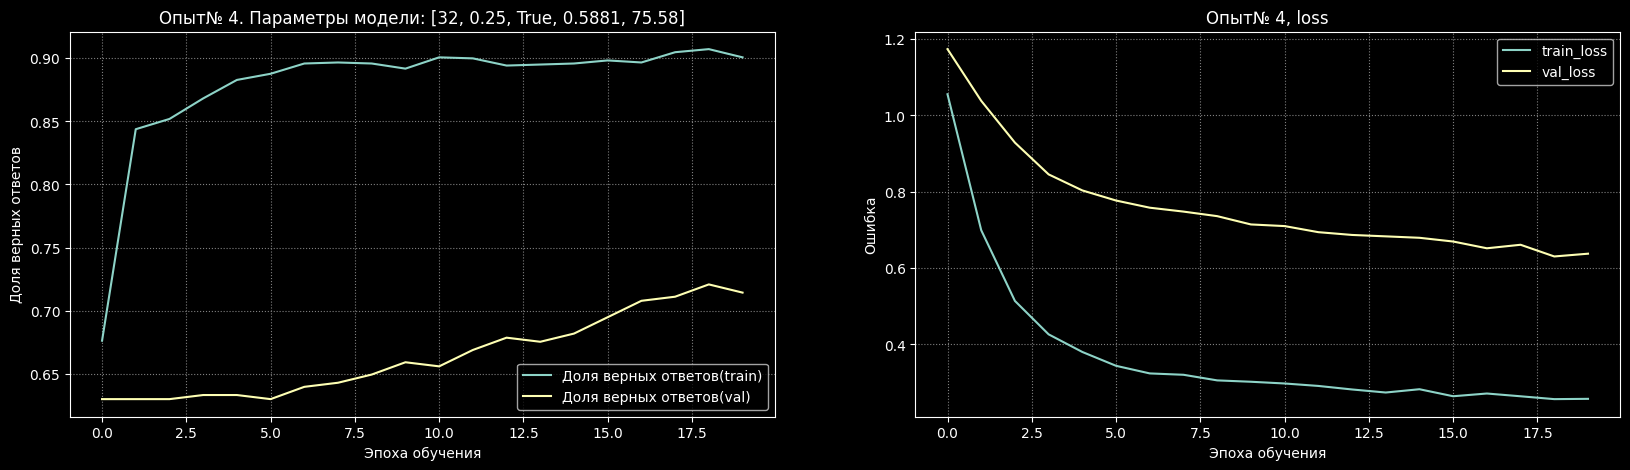

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.7705
 Средняя точность на тестовойой выборке: 70.39

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



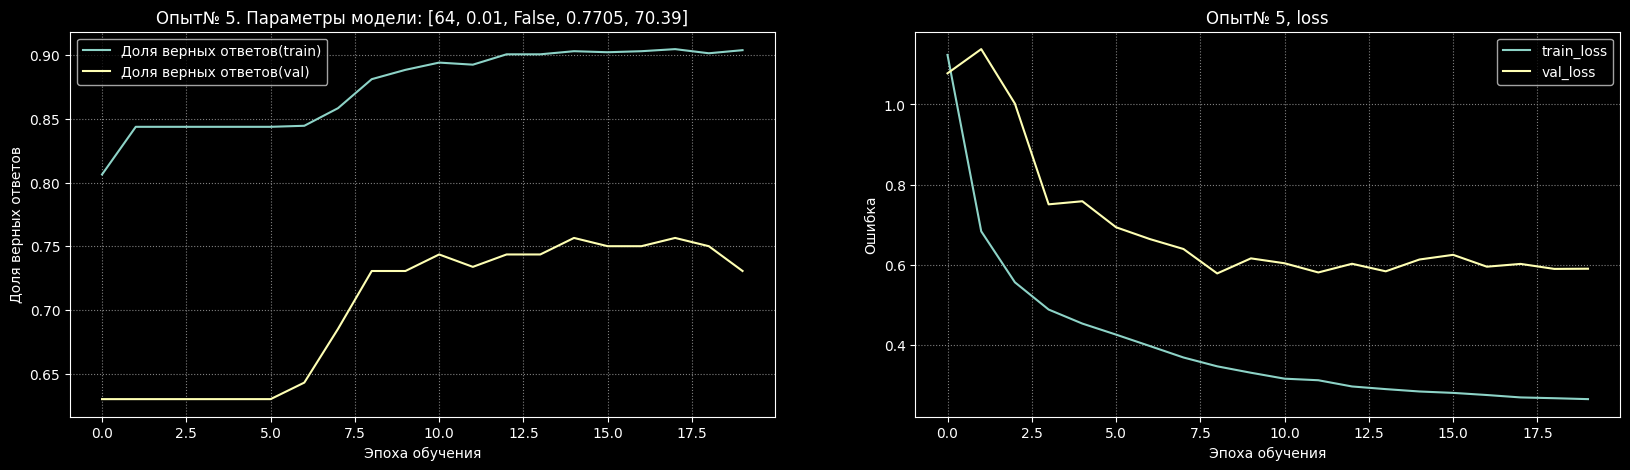

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.6922
 Средняя точность на тестовойой выборке: 72.99

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



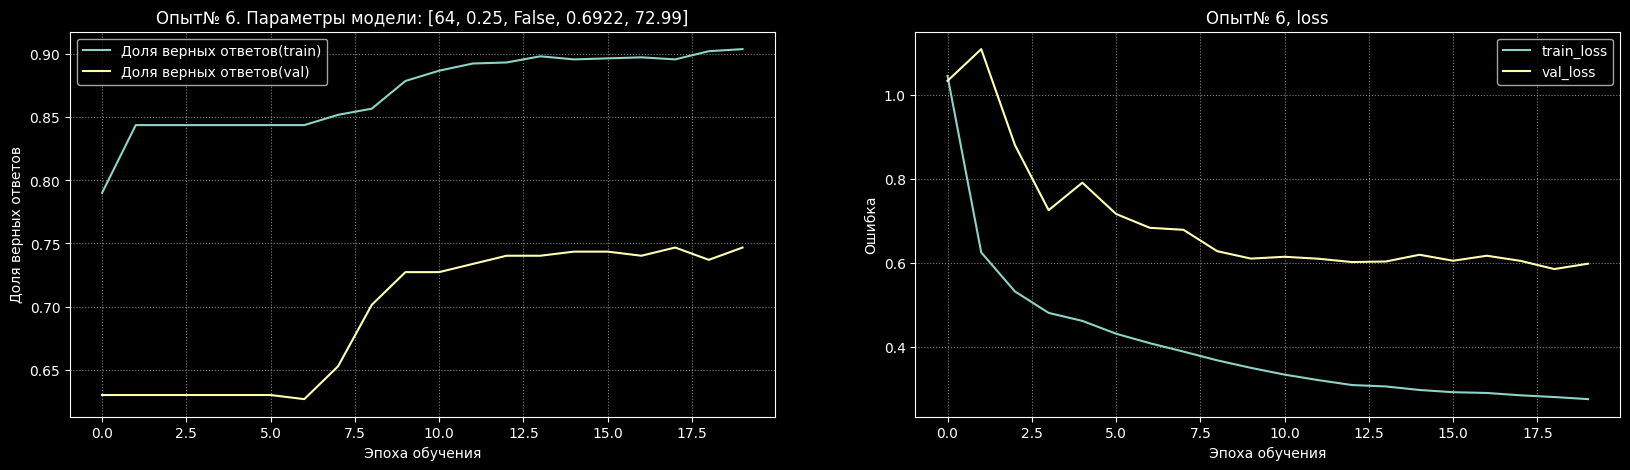

Входных Нейронов: 64
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.5477
 Средняя точность на тестовойой выборке: 77.66

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



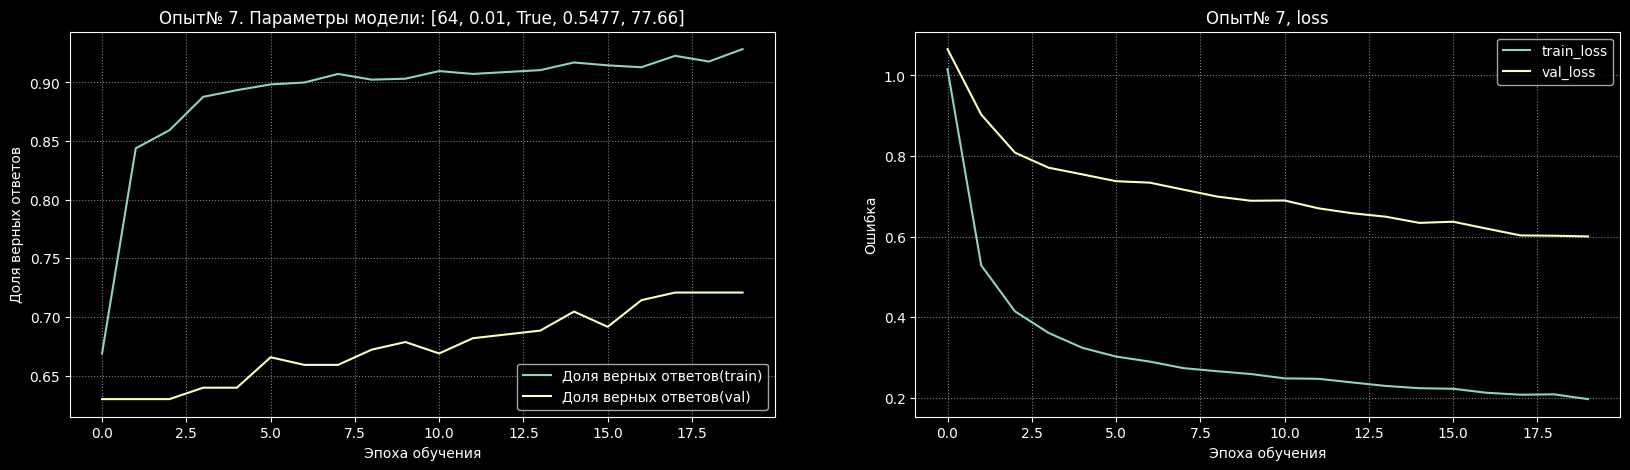

Входных Нейронов: 64
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.5482
 Средняя точность на тестовойой выборке: 77.14

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



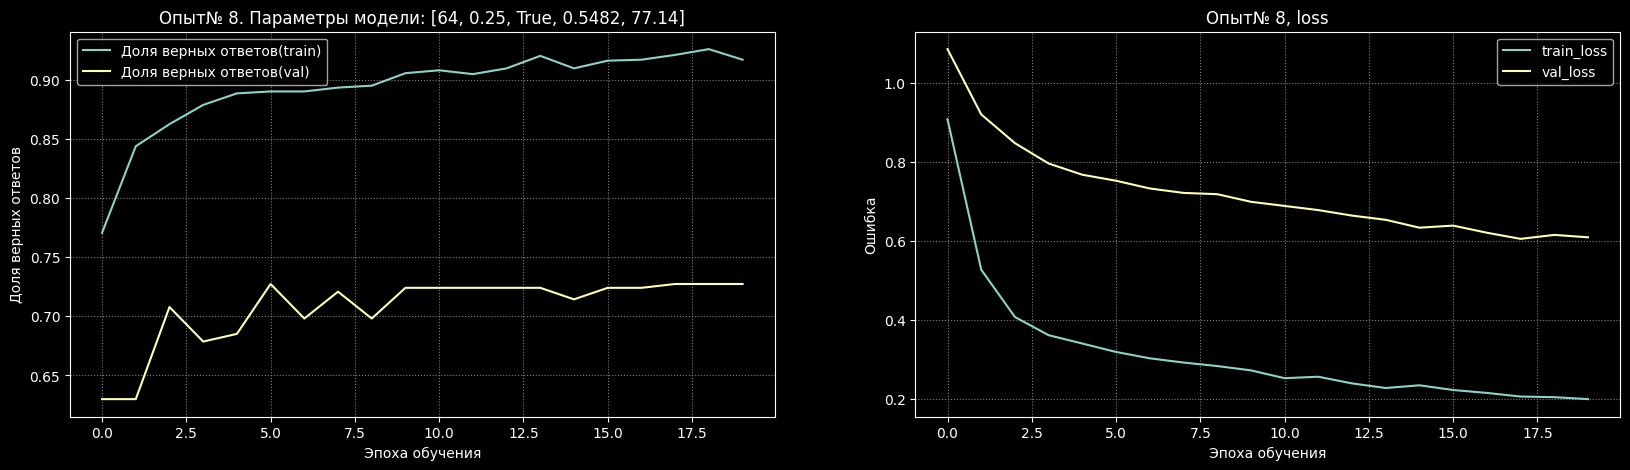

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.728
 Средняя точность на тестовойой выборке: 70.65

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



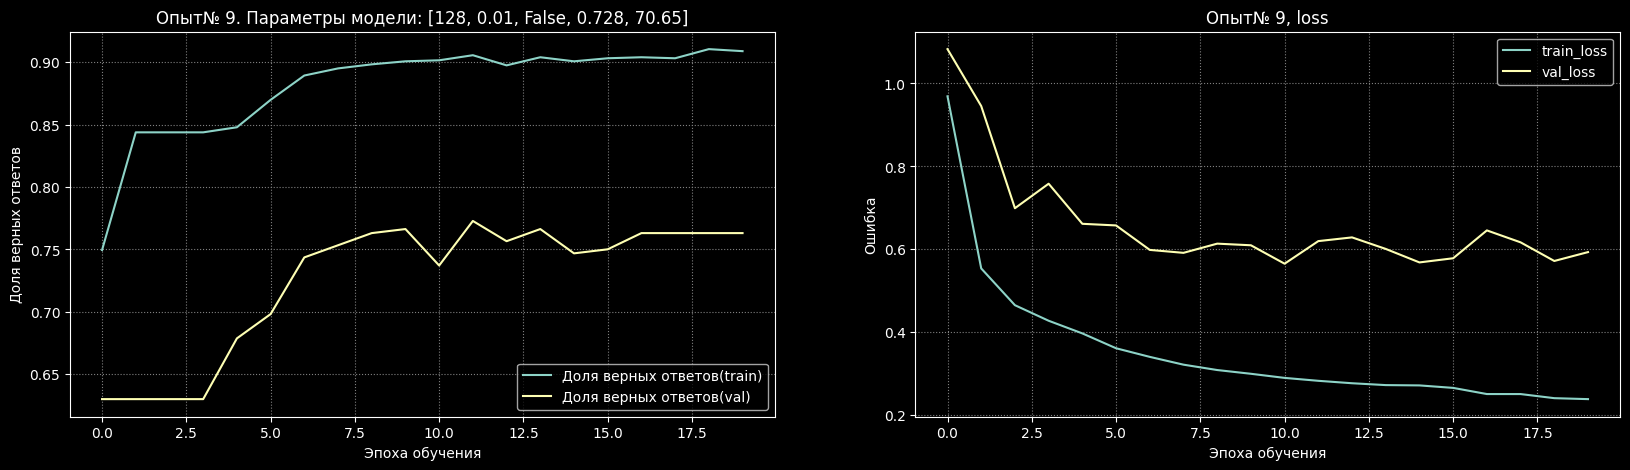

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.754
 Средняя точность на тестовойой выборке: 70.65

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



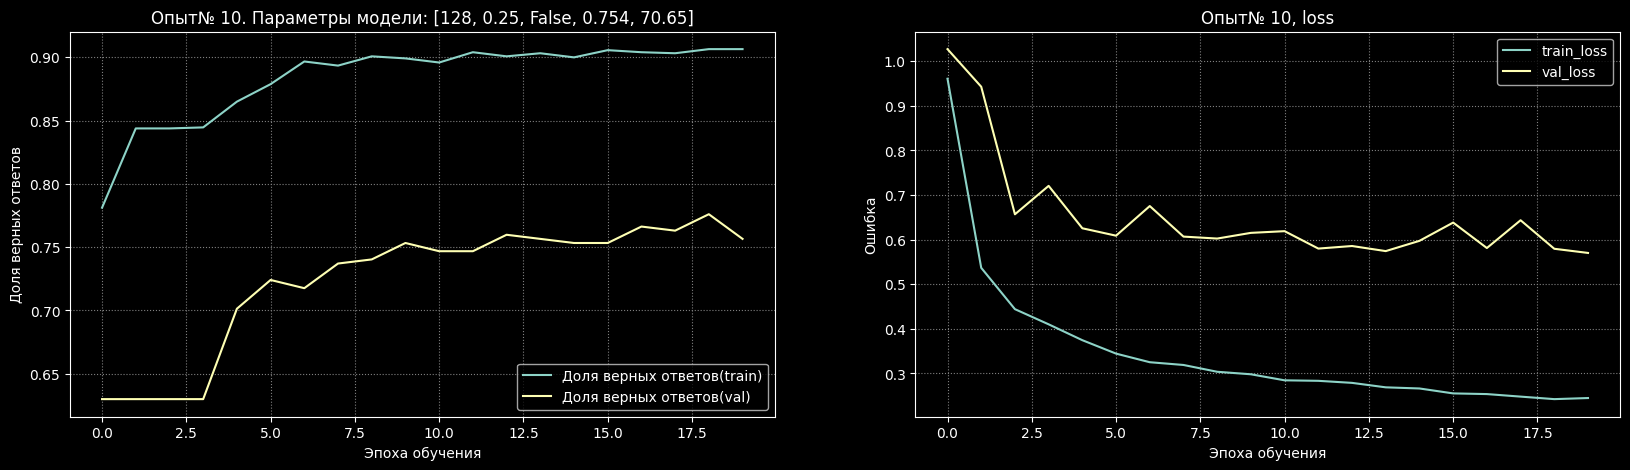

Входных Нейронов: 128
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.6331
 Средняя точность на тестовойой выборке: 75.58

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



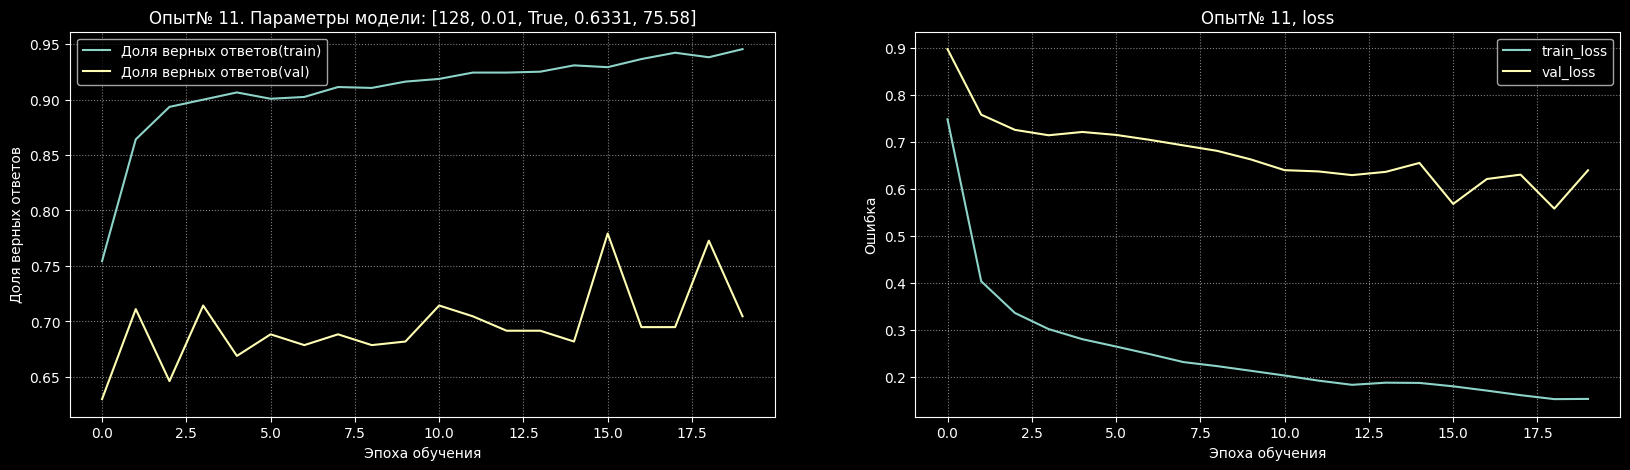

Входных Нейронов: 128
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.6295
 Средняя точность на тестовойой выборке: 76.1

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



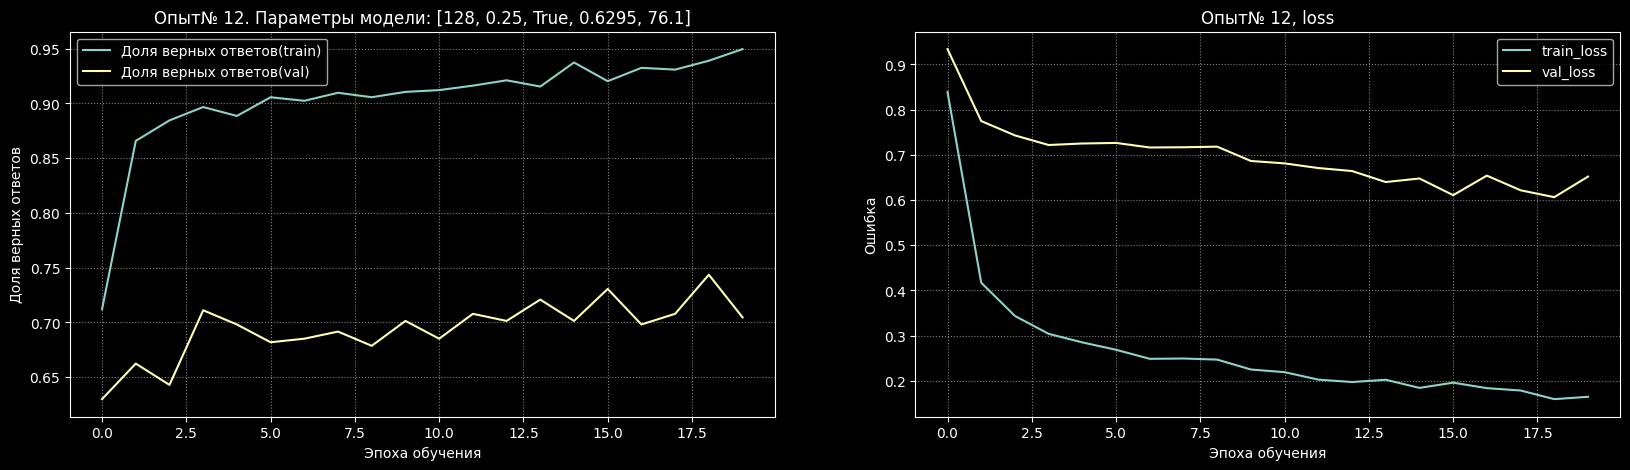

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: False
 Средние потери: 0.7216
 Средняя точность на тестовойой выборке: 74.03

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



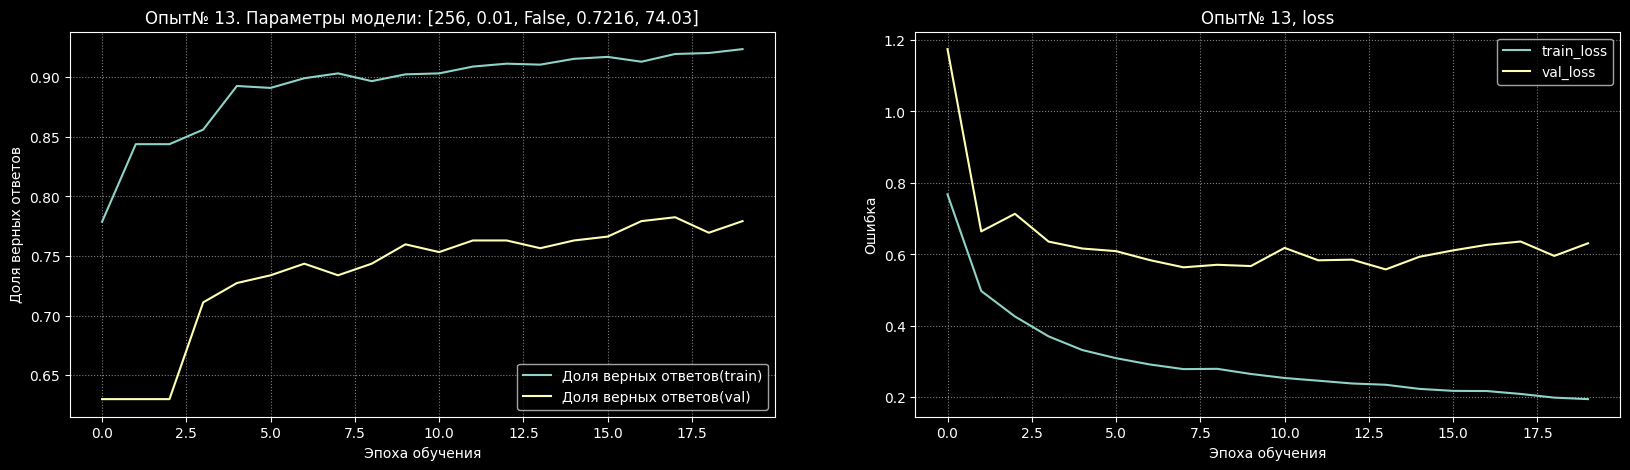

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: False
 Средние потери: 0.7247
 Средняя точность на тестовойой выборке: 73.25

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



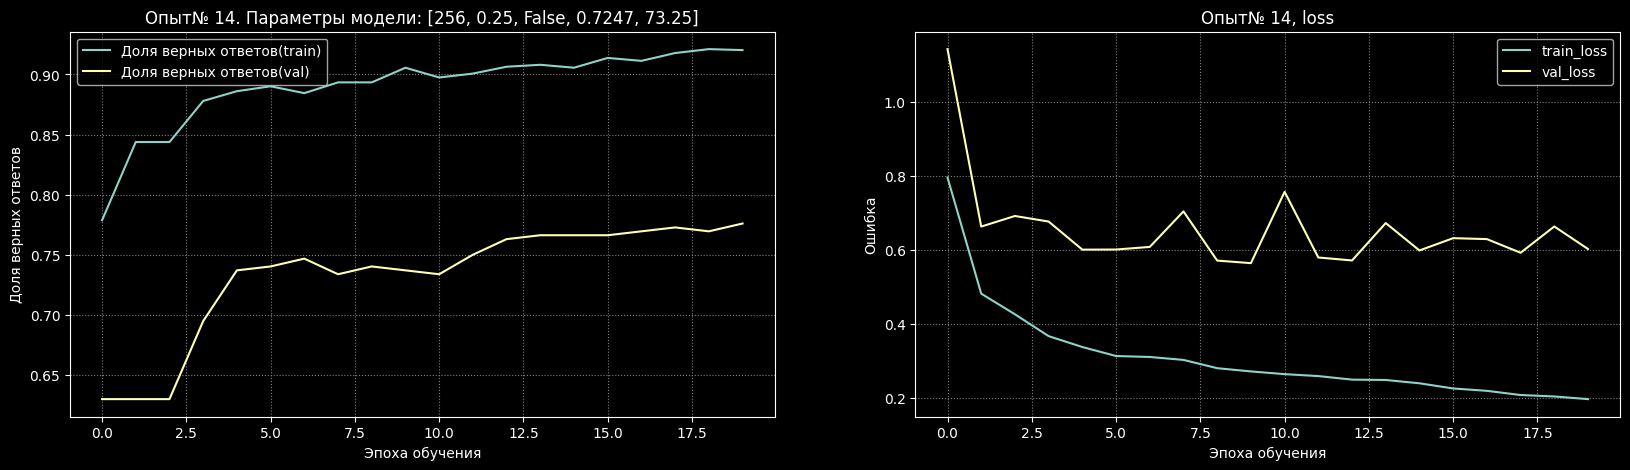

Входных Нейронов: 256
 Значение Dropout: 0.01
 BatchNormalization: True
 Средние потери: 0.6549
 Средняя точность на тестовойой выборке: 76.62

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



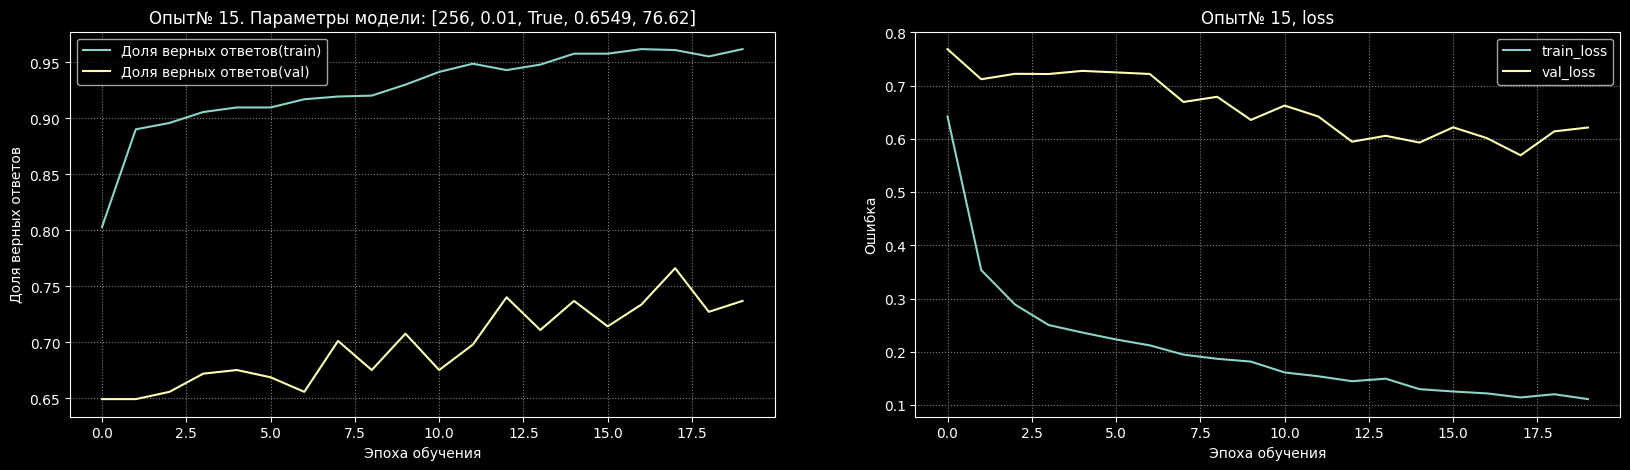

Входных Нейронов: 256
 Значение Dropout: 0.25
 BatchNormalization: True
 Средние потери: 0.6223
 Средняя точность на тестовойой выборке: 77.14

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓



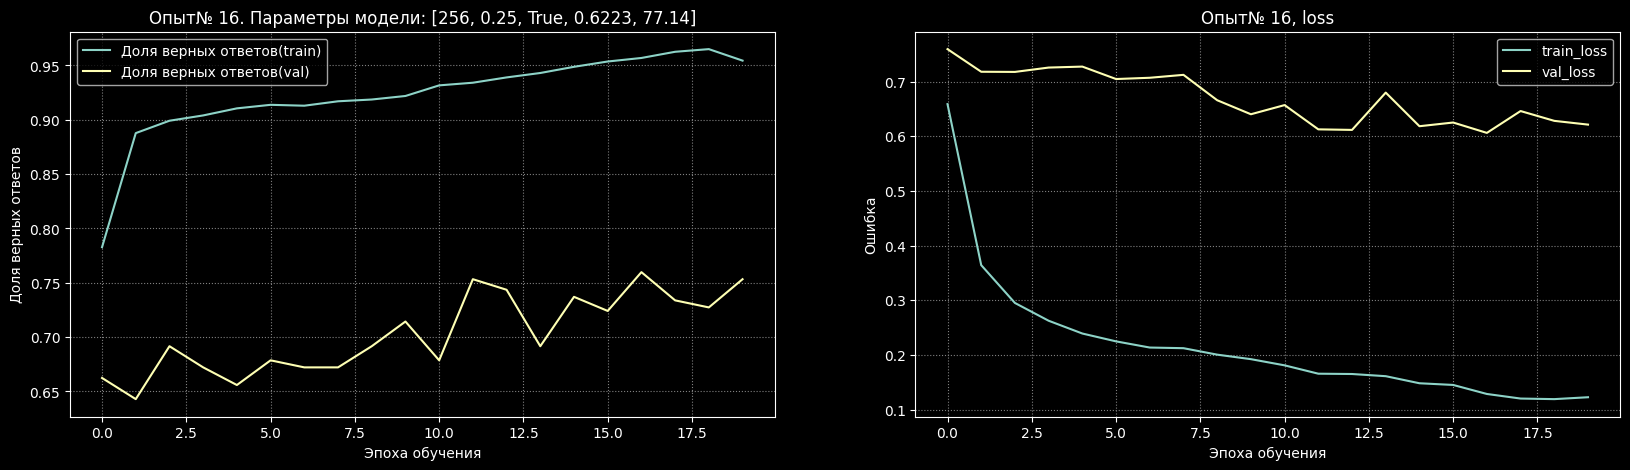

In [ ]:
for exp in range(len(val_loss)):
    graphic(loss[exp], acc[exp], val_loss[exp], val_acc[exp],
            par[exp][-1], par[exp][-2], exp, par[exp])

### Сводная таблица (1 слой)

Число Нейронов    Значение Dropout    BatchNormalization?   \
1                 32                0.01                  False   
2                 32                0.25                  False   
3                 32                0.01                   True   
4                 32                0.25                   True   
5                 64                0.01                  False   
6                 64                0.25                  False   
7                 64                0.01                   True   
8                 64                0.25                   True   
9                128                0.01                  False   
10               128                0.25                  False   
11               128                0.01                   True   
12               128                0.25                   True   
13               256                0.01                  False   
14               256                0.25                  False   
15               256                0.01                   True   
16               256                0.25                   True   

     Loss тестовой    Точность тестовой   
1            0.6124                74.29  
2            0.6119                74.03  
3            0.6080                75.06  
4            0.6118                74.81  
5            0.5930                74.55  
6            0.5996                75.06  
7            0.6336                75.32  
8            0.6102                74.81  
9            0.6254                73.51  
10           0.6175                74.29  
11           0.5651                76.62  
12           0.5835                76.10  
13           0.6728                73.77  
14           0.6521                72.73  
15           0.5702                77.40  
16           0.5734                76.88

### Сводная таблица (2 слоя)

2-й слой нейронов = Вх. слой * 4


Число Нейронов    Значение Dropout    BatchNormalization?   \
1                 32                0.01                  False   
2                 32                0.25                  False   
3                 32                0.01                   True   
4                 32                0.25                   True   
5                 64                0.01                  False   
6                 64                0.25                  False   
7                 64                0.01                   True   
8                 64                0.25                   True   
9                128                0.01                  False   
10               128                0.25                  False   
11               128                0.01                   True   
12               128                0.25                   True   
13               256                0.01                  False   
14               256                0.25                  False   
15               256                0.01                   True   
16               256                0.25                   True   

     Loss тестовой    Точность тестовой   
1            0.6923                71.95  
2            0.6737                72.73  
3            0.5724                76.88  
4            0.5881                75.58  
5            0.7705                70.39  
6            0.6922                72.99  
7            0.5477                77.66  
8            0.5482                77.14  
9            0.7280                70.65  
10           0.7540                70.65  
11           0.6331                75.58  
12           0.6295                76.10  
13           0.7216                74.03  
14           0.7247                73.25  
15           0.6549                76.62  
16           0.6223                77.14